# Brain MRI segmentation Kaggle

[Source of dataset](https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation)

**About dataset**

From Dataset README.md

Dataset consists of 110 patients MRI()  together with manual FLAIR (Fluid-attenuated inversion recovery) abnormality segmentation masks obtained from The Cancer Imaging Archive (TCIA).


data.csv contains patients data and Tumor genomic clusters.

Images are organized in  110 folders named after the CASE_ID.
Each folder contains MR images with the following naming convention:

    TCGA_<institution-code>_<patient-id>_<slice-number>.tif
Corresponding masks have a _mask suffix.

Images are in .tif format having 3 channels per image.

Out of 110 cases. 101 have all 3 channels present corresponding to pre-contrast, FLAIR, post-contrast (in this order of channels).

For the remaining cases, either pre-contrast or post-contrast is missing.

Missing sequences are replaced by FLAIR sequences.

The masks are 1 channel images.

### Objective:

Generation of segmentation masks for cancerous tumors in the human brain using 

the MRI scans and their respective masks.



### **Possible Evaluation Metrics:**

2.   Dice Coefficient: 
<img src= 'https://imgur.com/1UJ81aU.png' >


<img src= 'https://imgur.com/MPLS93W.png' >

        Pi  is predicted and 

        Gi is ground truth.

        Dice loss = 1 - Dice 


**Range of the loss function and Interpretation of loss function**

Dice ranges from [0 to 1], where 1 indicates the compelete and perfect overlap between the mask predicted and the actual mask.

Then Dice loss = 0 when perfect overlap 

Dice loss = 1 when no overlap between the mask and target.

1.   Tversky loss :  It is a generalization of Dice loss. It adds weights to False Positive and False Negatives.


![link text](https://imgur.com/73S0kks.png)

## Exploratory data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import cv2
import numpy as np
import imutils
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
from skimage import io

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download zillow/zecon -f State_time_series.csv

  0% 0.00/1.71M [00:00<?, ?B/s]
100% 1.71M/1.71M [00:00<00:00, 56.9MB/s]


In [4]:
!kaggle datasets download mateuszbuda/lgg-mri-segmentation 

 98% 697M/714M [00:19<00:00, 46.1MB/s]
100% 714M/714M [00:19<00:00, 38.7MB/s]


In [ ]:
!unzip /content/lgg-mri-segmentation.zip

In [7]:
df = pd.read_csv("/content/lgg-mri-segmentation/kaggle_3m/data.csv")
df.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


In [8]:
df.shape

(110, 18)

In [9]:
df.describe()

,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
count,92.000000,109.000000,110.000000,108.000000,98.000000,105.000000,110.000000,109.000000,109.000000,109.0,109.000000,109.000000,109.000000,109.000000,108.000000,102.000000,109.000000
mean,2.445652,3.678899,1.900000,1.722222,2.367347,1.895238,1.763636,2.128440,1.532110,1.0,2.009174,3.513761,1.486239,45.834862,2.907407,1.970588,0.247706
std,1.180092,1.169684,0.789263,0.862872,1.125045,0.663960,0.855927,0.850935,0.501273,0.0,0.995317,1.863960,0.502119,13.797151,0.291212,0.169792,0.433674
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,20.000000,2.000000,1.000000,0.000000
25%,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,2.000000,1.000000,34.000000,3.000000,2.000000,0.000000
50%,2.000000,4.000000,2.000000,1.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.0,2.000000,2.000000,1.000000,47.000000,3.000000,2.000000,0.000000
75%,4.000000,5.000000,2.000000,3.000000,3.000000,2.000000,3.000000,3.000000,2.000000,1.0,3.000000,6.000000,2.000000,58.000000,3.000000,2.000000,0.000000
max,4.000000,5.000000,4.000000,3.000000,4.000000,3.000000,3.000000,3.000000,2.000000,1.0,3.000000,6.000000,2.000000,75.000000,3.000000,2.000000,1.000000


In [10]:
df.dtypes

Patient                       object
RNASeqCluster                float64
MethylationCluster           float64
miRNACluster                   int64
CNCluster                    float64
RPPACluster                  float64
OncosignCluster              float64
COCCluster                     int64
histological_type            float64
neoplasm_histologic_grade    float64
tumor_tissue_site            float64
laterality                   float64
tumor_location               float64
gender                       float64
age_at_initial_pathologic    float64
race                         float64
ethnicity                    float64
death01                      float64
dtype: object

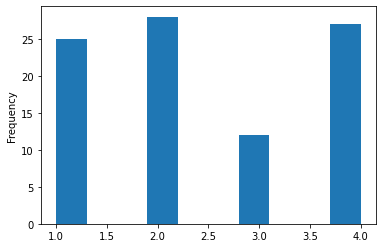

In [11]:
df["RNASeqCluster"].plot(kind = "hist",ylabel = "Number of RNASeqCluster")

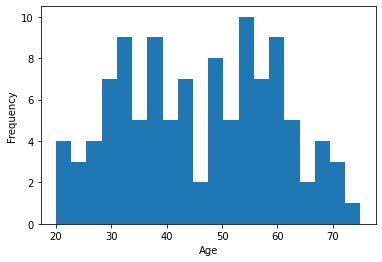

In [12]:
df["age_at_initial_pathologic"].plot(kind = "hist",bins = 20)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [13]:
df.groupby(by = "gender").count()["Patient"]

gender
1.0    56
2.0    53
Name: Patient, dtype: int64

Both the genders are almost equaly reprented in data set.

In [14]:
df["tumor_location"]

0      2.0
1      2.0
2      2.0
3      6.0
4      6.0
      ... 
105    2.0
106    2.0
107    2.0
108    6.0
109    NaN
Name: tumor_location, Length: 110, dtype: float64

In [15]:
PATH = "/content/lgg-mri-segmentation/kaggle_3m"
list_dir = []
for dir in os.listdir(PATH):
    dir = PATH + '/' + dir
    if os.path.isdir(dir):
        list_dir.append(dir)

In [16]:
MRI_image = []
MRI_mask = []
for i in range(len(list_dir)):
    directory_path = list_dir[i]
    for mask in os.listdir(directory_path):
        if '_mask' in mask:
            MRI_mask.append(directory_path + '/' + mask)
            mask = mask.replace('_mask','')
            MRI_image.append(directory_path + '/' + mask)



In [17]:
MRI_image[0],MRI_mask[0]

('/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_7.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_7_mask.tif')

In [18]:
len(MRI_image),len(MRI_mask),

(3929, 3929)

In [19]:
# Checking is all the images are proper files or not
for file in MRI_image:
    if not  os.path.isfile(file):
        print("error")

for file in MRI_mask:
    if not  os.path.isfile(file):
        print("error")

In [20]:
images_df = pd.DataFrame(data = zip(MRI_image,MRI_mask),columns= ['MRI_image', 'MRI_mask'])
images_df.head()

,MRI_image,MRI_mask
0,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...
1,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...
2,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...
3,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...
4,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...


In [21]:
images_df.shape

(3929, 2)

In total we have 3929 images and their respective masks.

In [22]:
images_df['MRI_image'][0], images_df['MRI_mask'][0]

('/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_7.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_7_mask.tif')

In [23]:
tiff_file = images_df['MRI_image'][0]
I = plt.imread(tiff_file)
tiff_file = images_df['MRI_mask'][0]
J = plt.imread(tiff_file)

#plt.plot(I)

In [24]:
I.shape, J.shape

((256, 256, 3), (256, 256))

##### Helper function

In [25]:
def plot_pair(image,mask):
    """
    Inputs: image and mask 
    Outputs: plot both image and plot side by side
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 5))
    axes[0].imshow(image)
    axes[0].get_xaxis().set_visible(False)
    axes[0].get_yaxis().set_visible(False)
    axes[1].imshow(mask)
    axes[1].get_xaxis().set_visible(False)
    axes[1].get_yaxis().set_visible(False)
    fig.tight_layout()

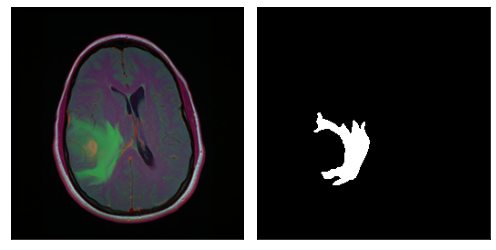

In [26]:
import cv2
image = cv2.imread(images_df['MRI_image'][4])
mask = cv2.imread(images_df['MRI_mask'][4])

plot_pair(image,mask)

In [27]:
def istumor(mask_img):
    """
    Finding wheather the mask has tumor or not
    """
    mask_img = cv2.imread(mask_img)
    k = np.max(mask_img)
    return 1 if k>0 else 0

In [28]:
images_df["is_tumor"] = images_df['MRI_mask'].apply(istumor)

In [29]:
images_df.head()

,MRI_image,MRI_mask,is_tumor
0,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,0
1,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,1
2,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,0
3,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,1
4,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,1


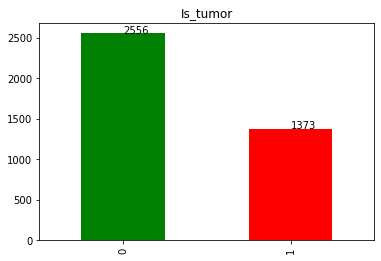

In [30]:
ax = images_df["is_tumor"].value_counts().plot(kind = "bar",title = "Is_tumor",color=['g','r'] )
for patch in ax.patches:
    #print(patch)
    ax.annotate(xy = (patch.get_x() + 0.25 ,patch.get_height()+0.5 ),s = str(patch.get_height()) )

In [31]:
print("Percentage of patients with no tumor", str( (images_df["is_tumor"].value_counts()[0]/ images_df["is_tumor"].value_counts().sum() ) *100) )
print("Percentage of patients with  tumor", str( (images_df["is_tumor"].value_counts()[1]/ images_df["is_tumor"].value_counts().sum() ) *100) )

Percentage of patients with no tumor 65.05472130313056
Percentage of patients with  tumor 34.94527869686943


In [32]:
print(patch)

Rectangle(xy=(0.75, 0), width=0.5, height=1373, angle=0)


In [33]:
no_tumor = images_df[images_df["is_tumor"] == 0 ].sample(3)
yes_tumor = images_df[images_df["is_tumor"] ==  1].sample(3)

In [34]:
no_tumor.index

Int64Index([941, 3289, 1089], dtype='int64')

In [35]:
no_tumor.loc[3289]

MRI_image    /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
MRI_mask     /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
is_tumor                                                     0
Name: 3289, dtype: object

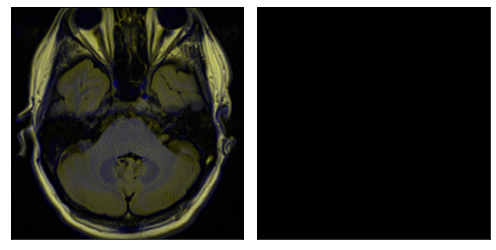

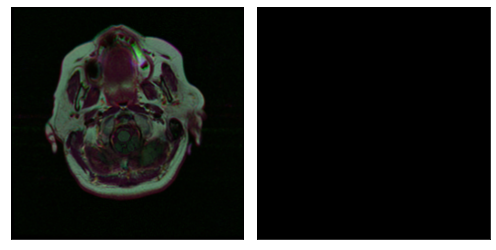

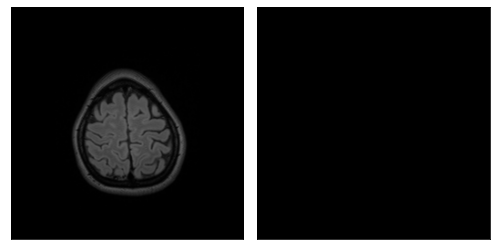

In [36]:
# Sample of no tumor 
for i in no_tumor.index:
    image = cv2.imread(no_tumor.loc[i]['MRI_image'])
    mask = cv2.imread(no_tumor.loc[i]['MRI_mask'])
    plot_pair(image,mask)

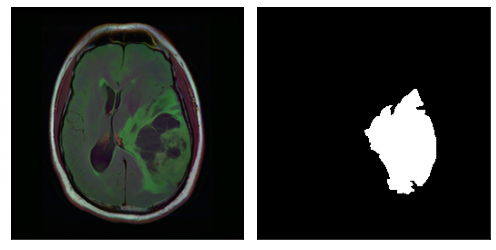

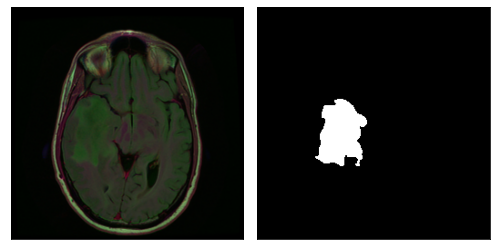

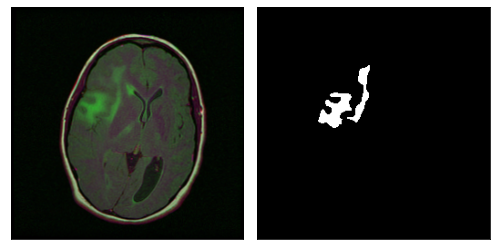

In [37]:
# Sample of  tumor images and mask
for i in yes_tumor.index:
    image = cv2.imread(yes_tumor.loc[i]['MRI_image'])
    mask = cv2.imread(yes_tumor.loc[i]['MRI_mask'])
    plot_pair(image,mask)

**Observations**


Not all brain scans are of same sizes , some brains are bigger and some are smaller in size.

Size of tumor also varies in the segmentation masks.

There are no segmentation masks present for scans with no tumor.

As 65% of patients have no tumor, it's reasonable to create a classification model to separate patients which are having tumors.

## Data augmentation



In [ ]:
image = cv2.imread(images_df['MRI_image'][4])
x= tf.image.random_flip_left_right(image, 5)
tf.image.flip_left_right(x)

## Segmentation


In [39]:
#Data for segmentation
#tumor_df  = images_df[images_df["is_tumor"] == '1']
tumor_df  = images_df[images_df["is_tumor"] == 1]
tumor_df.shape

(1373, 3)

In [40]:
X_train,X_val = train_test_split(tumor_df, test_size=0.2)
X_test,X_val = train_test_split(tumor_df, test_size=0.5)

print("Train data shape", X_train.shape)
print("Test data shape", X_test.shape)
print("Validation data shape", X_val.shape)

Train data shape (1098, 3)
Test data shape (686, 3)
Validation data shape (687, 3)


In [41]:
np.arange(5)

array([0, 1, 2, 3, 4])

#### Datagenerator Class

In [42]:
#ref: https://stackoverflow.com/questions/63938312/keras-flow-from-dataframe-for-image-segmentation-i-e-with-a-binary-mask-as-lab  Nice work
# Better way is DataGernerator class
# ref: https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3
# ref: https://www.kaggle.com/tushifire/tumor-sign-detection-segmentation-resunet


class Datagenerator(tf.keras.utils.Sequence):
    def __init__(self,df, X_col,Y_col ,img_h , img_w ,batch_size = 16, shuffle = True):
        self.batch_size = batch_size
        self.df = df
        self.n = len(self.df)

        self.X_col = X_col
        self.Y_col = Y_col
        self.img_h = img_h
        self.img_w = img_w
        self.shuffle = shuffle
        self.on_epoch_end()


    def __len__(self):
        """
        It is returns the number of batches .
        Complusory method
        """
        return int( self.n/self.batch_size)

    
    def __getitem__(self, index):
        """
        Returns a batch of input image and its respective mask.
        """
        # Getting indices of length batcg size
        indices = self.indices[ index * self.batch_size : (index +1) * self.batch_size]

        X,Y = self.__data_generation(indices)

        return X,Y


    def on_epoch_end(self):
        """
        Shuffling indices after each epoch
        """
        self.indices = np.array(self.df.index) #np.arange(self.n)

        if self.shuffle:
            #self.indices = np.random.permutation( self.indices )
            np.random.shuffle(self.indices)

    def __data_generation(self,indices):
        """
        Return a single batch of (X,Y) of images and there segmentation mask
        with preprocessing applied.

        """
        X = np.empty((self.batch_size,self.img_h,self.img_w, 3 )) # input is 3 channel
        Y = np.empty((self.batch_size,self.img_h,self.img_w, 1 )) # mask is 1 channel

        for i in range(self.batch_size):
            idx = indices[i]
            img_path = str(self.df.loc[idx]['MRI_image'])

            mask_path = str(self.df.loc[idx]['MRI_mask'])

            img = io.imread(img_path)
            mask = io.imread(mask_path)

            # resize img and convert to array
            img = cv2.resize(img,(self.img_h, self.img_w))
            img = np.array(img, dtype = np.float64)

            # resize mask and convert to array
            mask = cv2.resize(mask,(self.img_h, self.img_w))
            mask = np.array(mask, dtype = np.float64)

            #standardising , This has improved the performance of model and images are better visible
            img -= img.mean()
            img /= img.std()

            mask -= mask.mean()
            mask /= mask.std()

            #print(i)
            #print(img.shape,mask.shape)

            X[i,] = img

            Y[i,] = np.expand_dims(mask,axis = 2)

        Y = (Y > 0).astype(int)
        #print(X.shape,Y.shape)

        
        return X,Y



In [43]:
np.array(X_train.index)

array([ 292, 3534, 2027, ..., 2730,  436,  845])

In [44]:
idx = X_train.index[58]

In [50]:
img_h = 256
img_w = 256
img_path = str(X_train.loc[idx]['MRI_image'])

mask_path = str(X_train.loc[idx]['MRI_mask'])

img = io.imread(img_path)
mask = io.imread(mask_path)

# resize img and convert to array
img = cv2.resize(img,(img_h, img_w))
img = np.array(img, dtype = np.float64)

#resize mask and convert to array
mask = cv2.resize(mask,(img_h,img_w))
mask = np.array(mask, dtype = np.float64)

#standardising 
img -= img.mean()
img /= img.std()

mask -= mask.mean()
mask /= mask.std()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


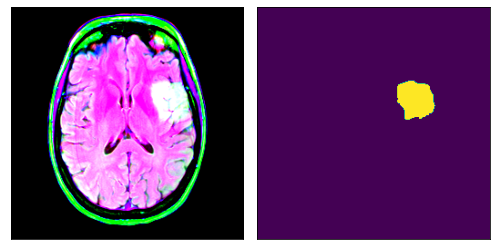

In [51]:
plot_pair(img,mask)

In [52]:
X_train.loc[2027]

MRI_image    /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...
MRI_mask     /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...
is_tumor                                                     1
Name: 2027, dtype: object

In [53]:
train_data = Datagenerator(df = X_train ,X_col= "MRI_image", Y_col="MRI_mask",img_h = 256 , img_w = 256 )
val_data = Datagenerator(df = X_val ,X_col= "MRI_image", Y_col="MRI_mask",img_h = 256 , img_w = 256 )

In [ ]:
train_data.__getitem__(4)[0].shape, train_data.__getitem__(4)[1].shape

((16, 256, 256, 3), (16, 256, 256, 1))

In [ ]:
path = '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_22.tif'
image = tf.keras.preprocessing.image.load_img(path)
image_arr = tf.keras.preprocessing.image.img_to_array(image)

#### Focal tversky loss to tackle class imbalance

ref: https://towardsdatascience.com/dealing-with-class-imbalanced-image-datasets-1cbd17de76b5

![](https://imgur.com/3Fz3Q0l.png)


By setting α >  𝜷 it penalizes FN more

The Focal Tversky Loss (FTL) is a generalisation of the tversky loss. The non-linear nature of the loss gives you control over how the loss behaves at different values of the tversky index obtained.




Best parameter will need some try and error.


Default paramenter that works as good starting point.


α = 0.7, 𝜷 = 0.3, γ = 3/4

### Unet model

In [54]:
#ref: https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py

# ref: https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch

from keras.losses import binary_crossentropy
import keras.backend as K
import tensorflow as tf

smooth=1e-6

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true,tf.float32)
    y_pred = tf.cast(y_pred,tf.float32)
    #pt_1 = tversky(y_true, y_pred)
    #print(pt_1)
    gamma = 0.75
    return K.pow((1-tversky(y_true, y_pred)), gamma)


In [56]:
def resblock(X,filters):

    X_side = X
    X = tf.keras.layers.Conv2D(filters, kernel_size = (1,1))(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation("relu")(X)

    #padding='valid' is default
    X = tf.keras.layers.Conv2D(filters,padding='same', kernel_size = (3,3))(X)
    X = tf.keras.layers.BatchNormalization()(X)

    #side path
    X_side = tf.keras.layers.Conv2D(filters, kernel_size = (1,1))(X_side)
    X_side = tf.keras.layers.BatchNormalization()(X_side)

    # Adding both the path

    X = tf.keras.layers.Add()([X, X_side])
    X = tf.keras.layers.Activation("relu")(X)

    return X


def upsample(X,X_side):
    """
    Upsampling and concatination with the side path
    """

    X = tf.keras.layers.UpSampling2D((2,2))(X)
    concat = tf.keras.layers.Concatenate()([X,X_side])
    return concat

In [57]:
input_shape = (256,256,3)

input = tf.keras.Input(input_shape)

#Stage1
conv_1 = tf.keras.layers.Conv2D(16,padding='same', activation='relu', kernel_size = (3,3))(input)
conv_1 = tf.keras.layers.BatchNormalization()(conv_1)

conv_1 = tf.keras.layers.Conv2D(16,padding='same', activation='relu', kernel_size = (3,3))(conv_1)
conv_1 = tf.keras.layers.BatchNormalization()(conv_1)
pool_1 = tf.keras.layers.MaxPool2D((2,2))(conv_1)

#stage2
stage_2 = resblock(pool_1,32)
pool_2 = tf.keras.layers.MaxPool2D((2,2))(stage_2)

#stage3
stage_3 = resblock(pool_2,64)
pool_3 = tf.keras.layers.MaxPool2D((2,2))(stage_3)

#stage2
stage_4 = resblock(pool_3,128)
pool_4 = tf.keras.layers.MaxPool2D((2,2))(stage_4)


#bottle neck 
stage_5 = resblock(pool_4,256)


#upstage
print("stage_4 and stage_5" , stage_4.shape,stage_5.shape)

up_stage_1 = upsample(stage_5,stage_4)
#print(up_stage_1.shape)
up_stage_1 = resblock(up_stage_1,128)

print("up_stage_1 and stage_3" , up_stage_1.shape,stage_3.shape)

up_stage_2 = upsample(up_stage_1,stage_3)
up_stage_2 = resblock(up_stage_2,64)

print("up_stage_2 and stage_2" , up_stage_2.shape,stage_2.shape)

up_stage_3 = upsample(up_stage_2,stage_2)
up_stage_3 = resblock(up_stage_3,32)

print("up_stage_3 and conv_1" , up_stage_1.shape,conv_1.shape)
up_stage_4 = upsample(up_stage_3,conv_1)
up_stage_4 = resblock(up_stage_4,16)


output = tf.keras.layers.Conv2D(1,padding='same', activation='sigmoid', kernel_size = (1,1))(up_stage_4)
print(output.shape)


stage_4 and stage_5 (None, 32, 32, 128) (None, 16, 16, 256)
up_stage_1 and stage_3 (None, 32, 32, 128) (None, 64, 64, 64)
up_stage_2 and stage_2 (None, 64, 64, 64) (None, 128, 128, 32)
up_stage_3 and conv_1 (None, 32, 32, 128) (None, 256, 256, 16)
(None, 256, 256, 1)


In [58]:
segmentation_model = tf.keras.Model(input,output)
segmentation_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        batch_normalization[0][0]        
______________________________________________________________________________________________

In [59]:
tf.keras.backend.clear_session()
!rm ./logs -r
!rm /content/Segmentation_model_Unet.hdf5

rm: cannot remove './logs': No such file or directory
rm: cannot remove '/content/Segmentation_model_Unet.hdf5': No such file or directory


In [60]:
EarlyStopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                          patience=10,verbose=1,
                                                          min_delta = 0.00001) # Reduce patience to 7
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,
                              patience=5,min_delta=0.01,verbose=1,
                               min_lr=1e-12)
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= log_dir)


check_point = tf.keras.callbacks.ModelCheckpoint('Segmentation_Unet.hdf5', monitor='val_loss', verbose=1, save_best_only=True )

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01 ) # 0.001 deafault

In [61]:
segmentation_model.compile(optimizer = optimizer, 
                  loss = focal_tversky, 
                  metrics = [tversky]
                 )

In [62]:
model_hist = segmentation_model.fit(train_data, validation_data = val_data,
          callbacks= [EarlyStopping_callback,check_point,reduce_lr,tensorboard_callback ],epochs = 50)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/50
68/68 [==============================] - 64s 450ms/step - loss: 0.5661 - tversky: 0.5252 - val_loss: 0.9890 - val_tversky: 0.0146

Epoch 00001: val_loss improved from inf to 0.98902, saving model to Segmentation_Unet.hdf5
Epoch 2/50
68/68 [==============================] - 29s 429ms/step - loss: 0.4320 - tversky: 0.6708 - val_loss: 0.8577 - val_tversky: 0.1846

Epoch 00002: val_loss improved from 0.98902 to 0.85768, saving model to Segmentation_Unet.hdf5
Epoch 3/50
68/68 [==============================] - 29s 429ms/step - loss: 0.3975 - tversky: 0.7047 - val_loss: 0.8899 - val_tversky: 0.1438

Epoch 00003: val_loss did not improve from 0.85768
Epoch 4/50
68/68 [==============================] - 29s 430ms/step - loss: 0.3813 - tversky: 0.7221 - val_loss: 0.4206 - val_tversky: 0.6835

Epoch 00004: val_loss improved from 0.85768 to 0.42059, saving model to Segmentation_Unet.hdf5
Epoch 5/50
68/68 [==============================] - 29s 430ms/step - loss: 0.3526 - tversky: 0.7488 

There seems to be overfitting at the start of training the model.

But towards the end the difference between train and validation tversky accuracy i not much.

In [63]:
model_hist.history.keys()

dict_keys(['loss', 'tversky', 'val_loss', 'val_tversky', 'lr'])

In [64]:
segmentation_model_save = segmentation_model.to_json()

with open("segmentation_model_best.json", "w") as json_file:
    json_file.write(segmentation_model_save)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### Plotting performance of model

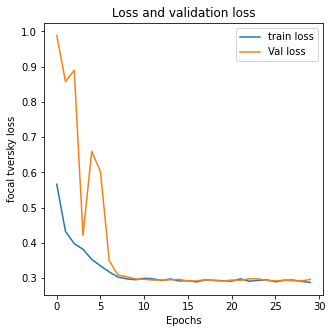

In [65]:
plt.figure(figsize=(5,5))
plt.title("Loss and validation loss")
plt.xlabel("Epochs")
plt.ylabel("focal tversky loss")
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.legend(['train loss','Val loss'])

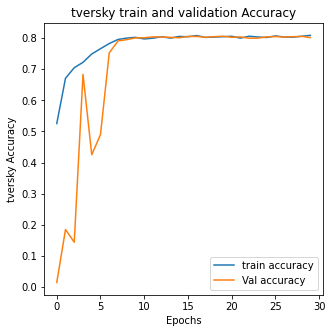

In [66]:
plt.figure(figsize=(5,5))
plt.title("tversky train and validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("tversky Accuracy")
plt.plot(model_hist.history['tversky'])
plt.plot(model_hist.history['val_tversky'])
plt.legend(['train accuracy','Val accuracy'])

In [67]:
test_data =  Datagenerator(df = X_test ,X_col= "MRI_image", Y_col="MRI_mask",img_h = 256 , img_w = 256 )


In [68]:
segmentation_model.evaluate(test_data)

42/42 [==============================] - 5s 120ms/step - loss: 0.2831 - tversky: 0.8128


[0.28314679861068726, 0.8127503991127014]

In [69]:
predictions = segmentation_model.predict(test_data)

In [ ]:
predictions

#### Prediction of segmentation mask


In [71]:
X_test.head()

,MRI_image,MRI_mask,is_tumor
497,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,1
3363,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
2924,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
2750,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
677,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1


In [72]:
ind = X_test.index
X_test.loc[ind[0]]['MRI_image']

'/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_26.tif'

In [73]:
def predict_segmentation_mask(image_path):
    # reads an brain MRI image
    img = io.imread(image_path)
    img = cv2.resize(img,(256,256))
    img = np.array(img, dtype=np.float64)
    img -= img.mean()
    img /= img.std()
    #img = np.reshape(img, (1,256,256,3) # this is the shape our model expects
    X = np.empty((1,256,256,3))
    X[0,] = img
    predict = segmentation_model.predict(X)

    return predict.reshape(256,256)



In [74]:
image_path = X_test.loc[ind[5]]['MRI_image']
original_mask = X_test.loc[ind[5]]['MRI_mask']
original_mask = cv2.imread(original_mask)
predicted_mask = predict_segmentation_mask(image_path)

In [75]:
def plot_mask_pair(original_mask,predicted_mask):
    """
    Inputs: image and mask 
    Outputs: plot both image and plot side by side
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 5))
    axes[0].imshow(original_mask)
    axes[0].get_xaxis().set_visible(False)
    axes[0].get_yaxis().set_visible(False)
    axes[1].imshow(predicted_mask)
    axes[1].get_xaxis().set_visible(False)
    axes[1].get_yaxis().set_visible(False)
    fig.tight_layout()

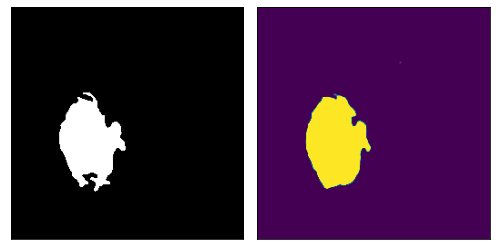

In [76]:
plot_mask_pair(original_mask,predicted_mask)

Some sample predictions

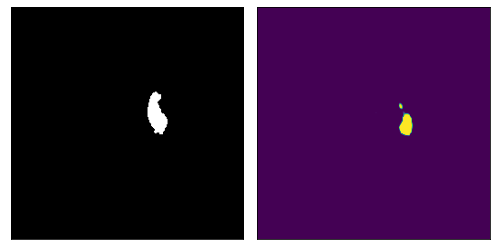

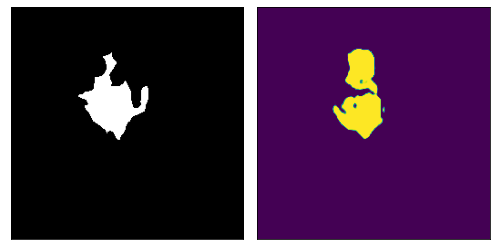

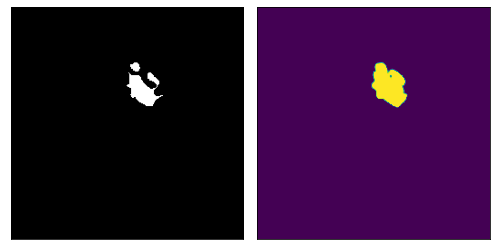

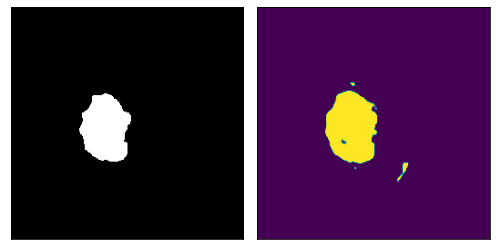

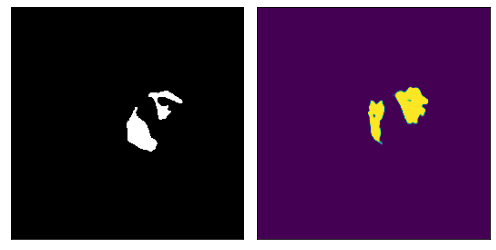

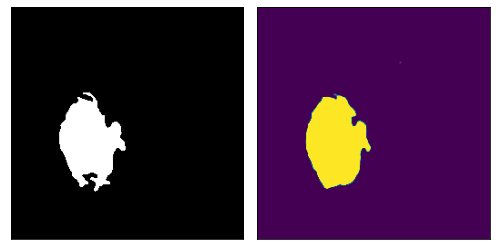

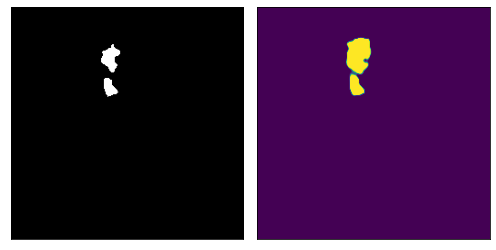

In [78]:
for i in range(7):
    image_path = X_test.loc[ind[i]]['MRI_image']
    original_mask = X_test.loc[ind[i]]['MRI_mask']
    original_mask = cv2.imread(original_mask)
    predicted_mask = predict_segmentation_mask(image_path)
    plot_mask_pair(original_mask,predicted_mask)
